In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 
# For using yaml configs.
%load_ext yamlmagic

In [2]:
train_dfc = rs.load_configs(
    root / "training/10_23_23_Dense_WMH",
    properties=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
train_dfc

,augmentations,data,annotator,axis,in_channels,num_slices,out_channels,preload,slicing,task,...,convs_per_block,filters,optim,lr,weight_decay,train_augmentations,epochs,eval_freq,pretrained_dir,path
0,null,ese.experiment.datasets.WMH,observer_o12,0,1,1,2,False,dense,Amsterdam,...,3,"(64, 64, 64, 64, 64)",torch.optim.Adam,0.0003,0.0,None,1000,10,None,/storage/vbutoi/scratch/ESE/training/10_23_23_...
1,"[{""RandomAffine"": {""degrees"": [0, 360], ""p"": 0...",ese.experiment.datasets.WMH,observer_o12,0,1,1,2,False,dense,Amsterdam,...,3,"(64, 64, 64, 64, 64)",torch.optim.Adam,0.0003,0.0,None,1000,10,None,/storage/vbutoi/scratch/ESE/training/10_23_23_...


In [4]:
from ese.experiment.analysis.inference import load_cal_inference_stats

inference_path = root / "inference/12_02_23_WMH_Binarize"
dataset = "WMH"

cal_inference_info = load_cal_inference_stats(
    log_dir=inference_path,
)

In [5]:
cal_inference_info.keys()

dict_keys(['pixel_info_dicts', 'image_info_df', 'metadata'])

In [6]:
metadata = cal_inference_info['metadata']

In [7]:
metadata.keys()

Index(['calibration.binarize', 'calibration.conf_interval_end',
       'calibration.conf_interval_start', 'calibration.neighborhood_width',
       'calibration.num_bins', 'calibration.square_diff', 'dataset._class',
       'dataset.annotator', 'dataset.axis', 'dataset.num_slices',
       'dataset.preload', 'dataset.slicing', 'dataset.split', 'dataset.task',
       'dataset.version', 'log.ignore_label', 'log.log_interval', 'log.root',
       'log.track_image_level', 'log.track_pixel_level', 'model.exp_root',
       'model.num_workers', 'log_set'],
      dtype='object')

## Pixel-level Analysis

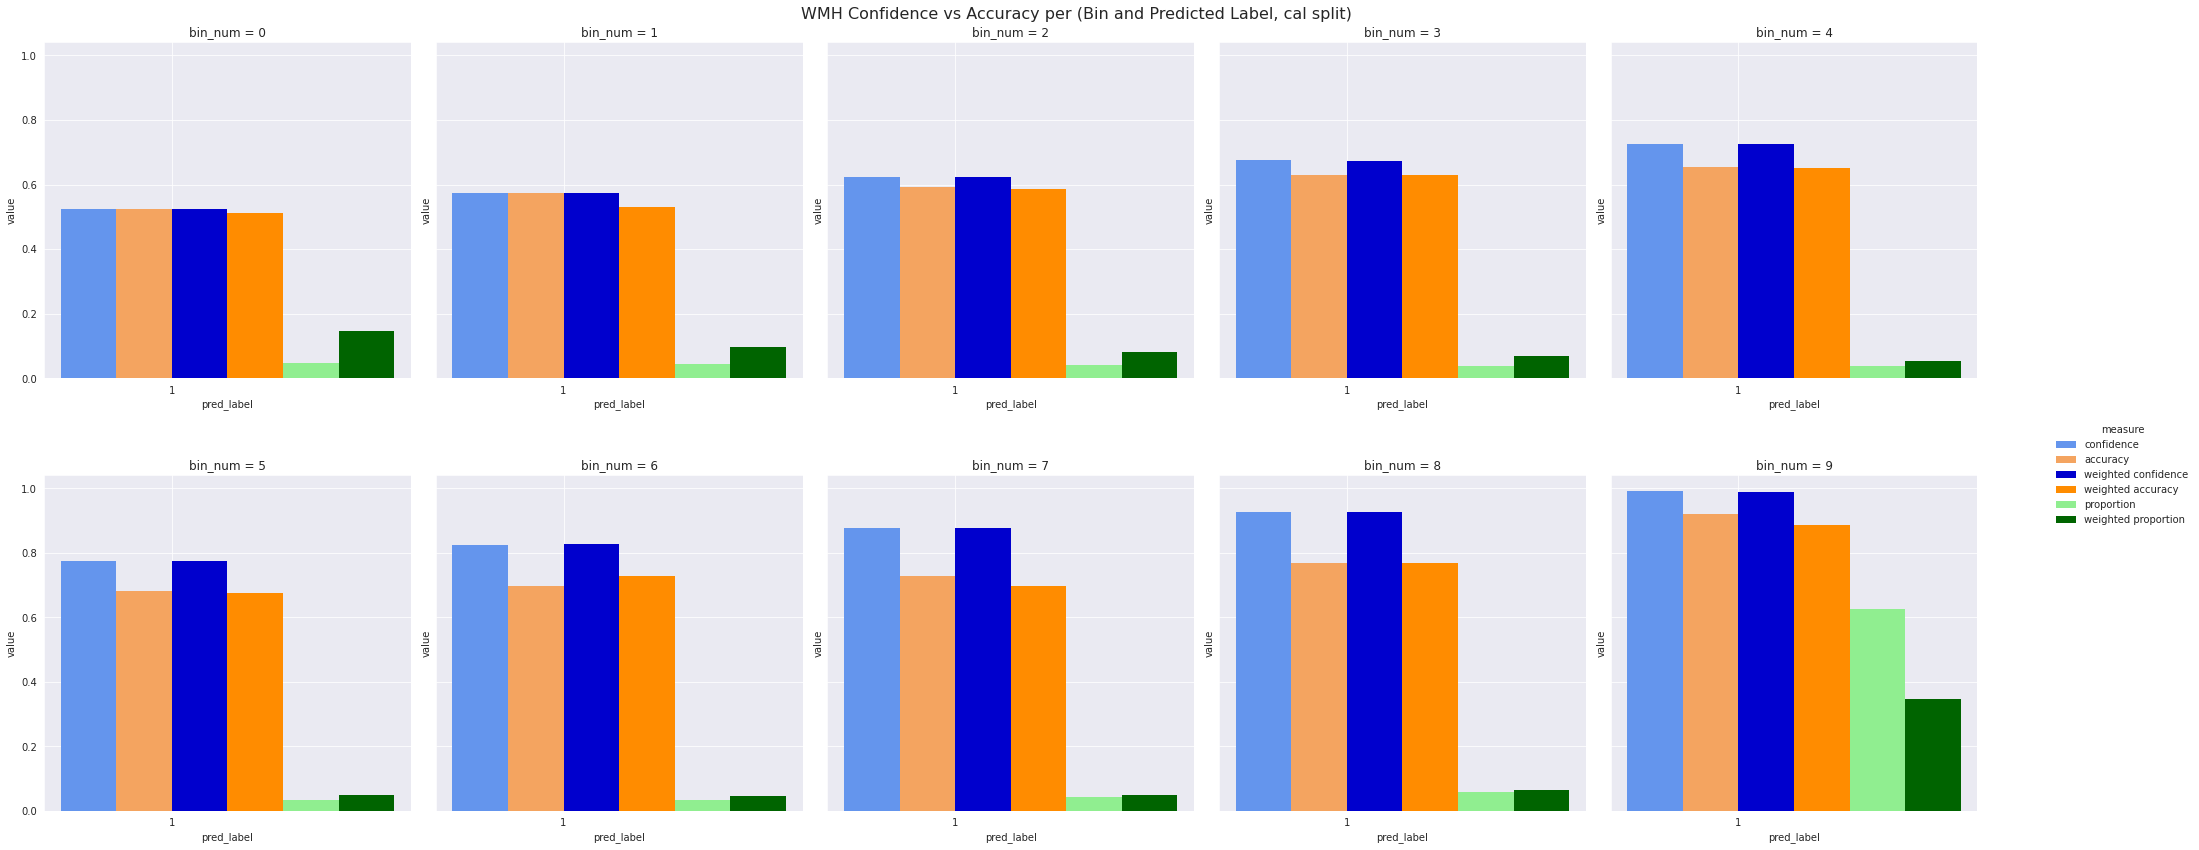

In [8]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence
from ese.experiment.analysis.utils import select_pixel_dict

for split in ["cal"]: 
    split_preds_dict = select_pixel_dict(
        pixel_meter_logdict=cal_inference_info["pixel_info_dicts"], 
        metadata=cal_inference_info["metadata"],
        kwargs={"dataset.split": split}
    ) 
    # Plot the accuracy vs confidence for this split.
    viz_accuracy_vs_confidence(
        split_preds_dict,
        title=f"{dataset} Confidence vs Accuracy per (Bin and Predicted Label, {split} split)",
        x="pred_label",
        col="bin_num",
        kind="bar",
        add_avg=False,
        facet_kws={'sharey': True, 'sharex': False}
        )

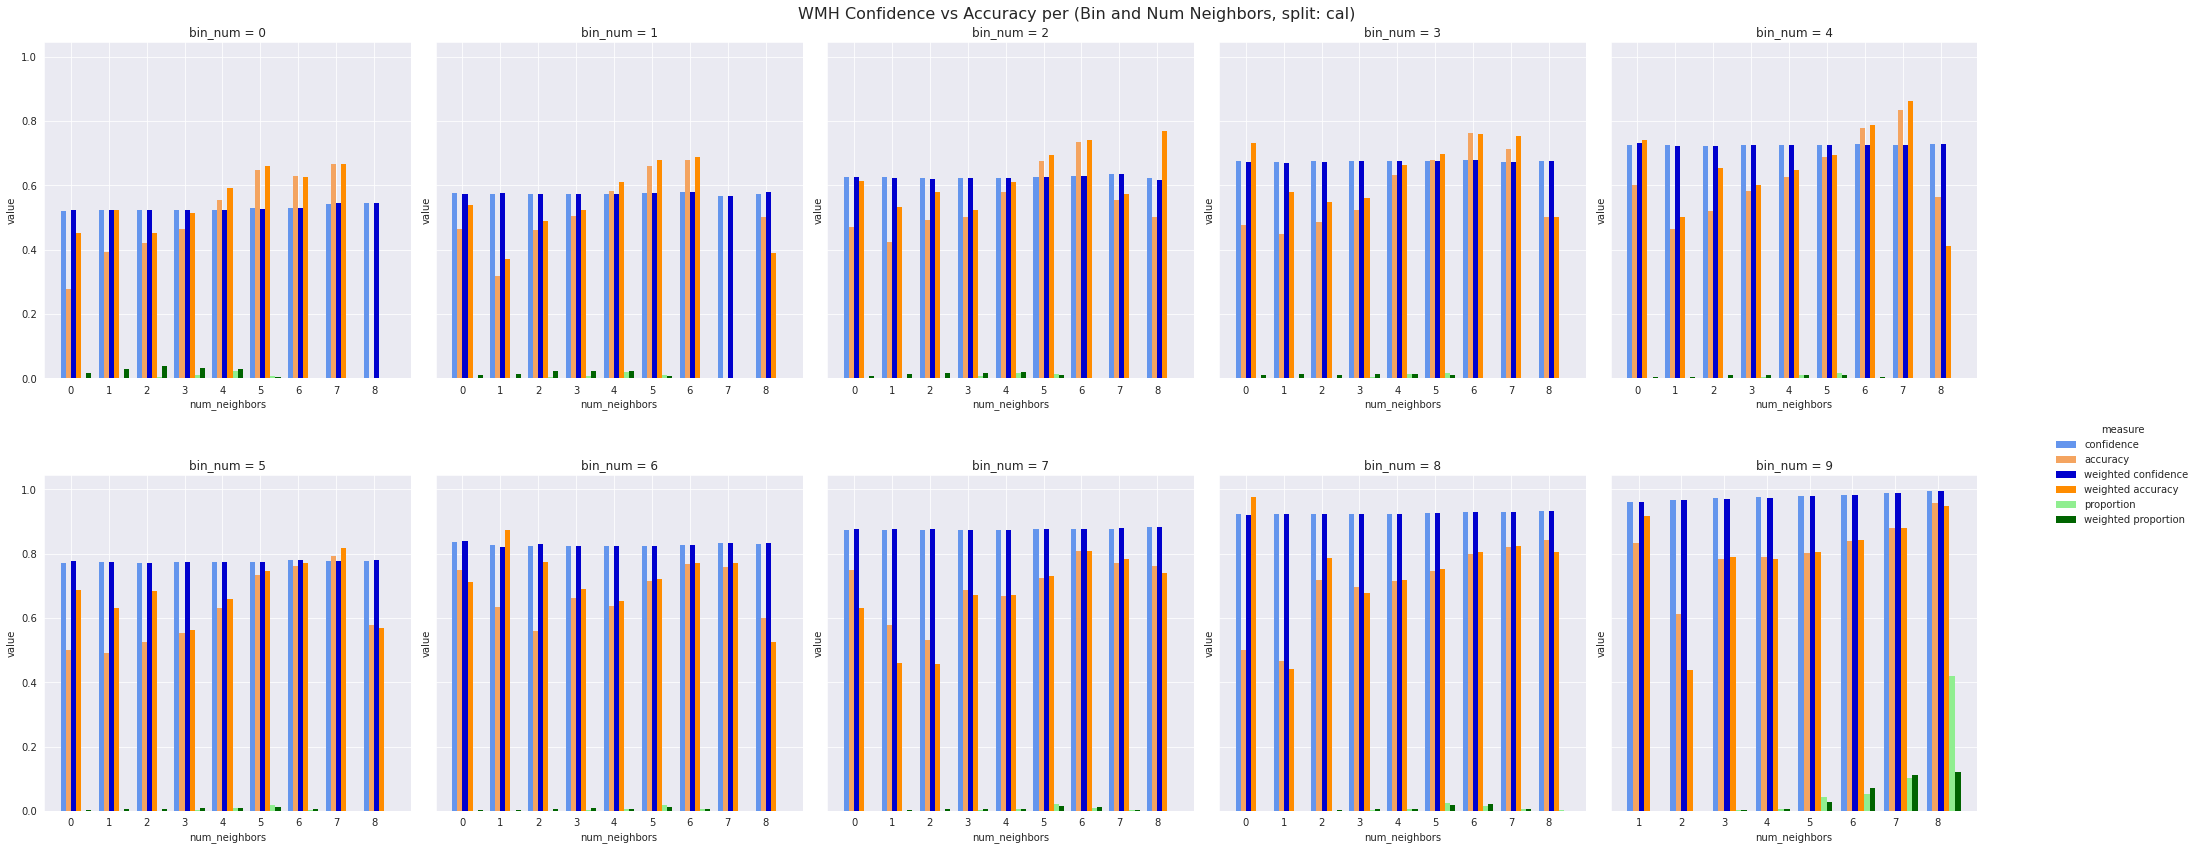

In [9]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence
from ese.experiment.analysis.utils import select_pixel_dict

for split in ["cal"]: 
    split_preds_dict = select_pixel_dict(
        pixel_meter_logdict=cal_inference_info["pixel_info_dicts"], 
        metadata=cal_inference_info["metadata"],
        kwargs={"dataset.split": split}
    ) 
    # Plot the accuracy vs confidence for this split.
    viz_accuracy_vs_confidence(
        split_preds_dict,
        title=f"{dataset} Confidence vs Accuracy per (Bin and Num Neighbors, split: {split})",
        x="num_neighbors",
        col="bin_num",
        kind="bar",
        add_avg=False,
        add_proportion=True,
        facet_kws={'sharey': True, 'sharex': False},
        )

## Image-level Analysis

In [10]:
image_info_df = cal_inference_info['image_info_df']

In [11]:
from ese.experiment.analysis.utils import reorder_splits

unique_image_df = reorder_splits(image_info_df.drop_constant())

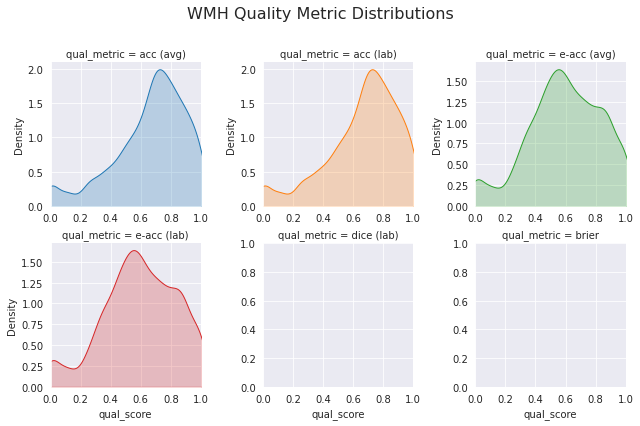

In [12]:
from ese.experiment.analysis.err_diagrams import viz_quality_metric_distributions

viz_quality_metric_distributions(
    unique_image_df, 
    title=f"{dataset} Quality Metric Distributions",
    col_wrap=3
)

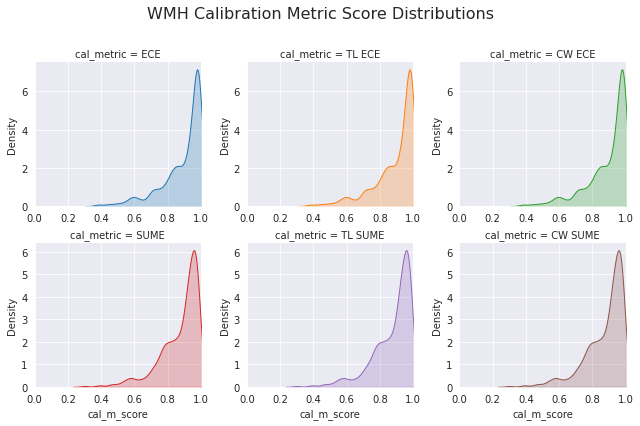

In [13]:
from ese.experiment.analysis.err_diagrams import viz_calibration_metric_distributions

viz_calibration_metric_distributions(
    unique_image_df, 
    title=f"{dataset} Calibration Metric Score Distributions",
    col_wrap=3
)

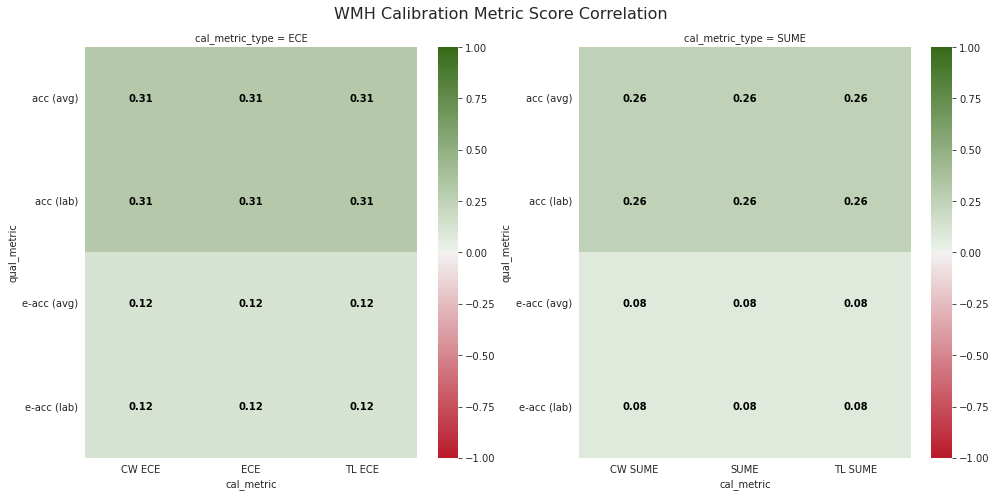

In [14]:
from ese.experiment.analysis.err_diagrams import viz_cal_metric_corr

viz_cal_metric_corr(
    unique_image_df,
    title=f"{dataset} Calibration Metric Score Correlation",
    heatmap_row="qual_metric",
    heatmap_col="cal_metric",
    col="cal_metric_type",
    height=7
)

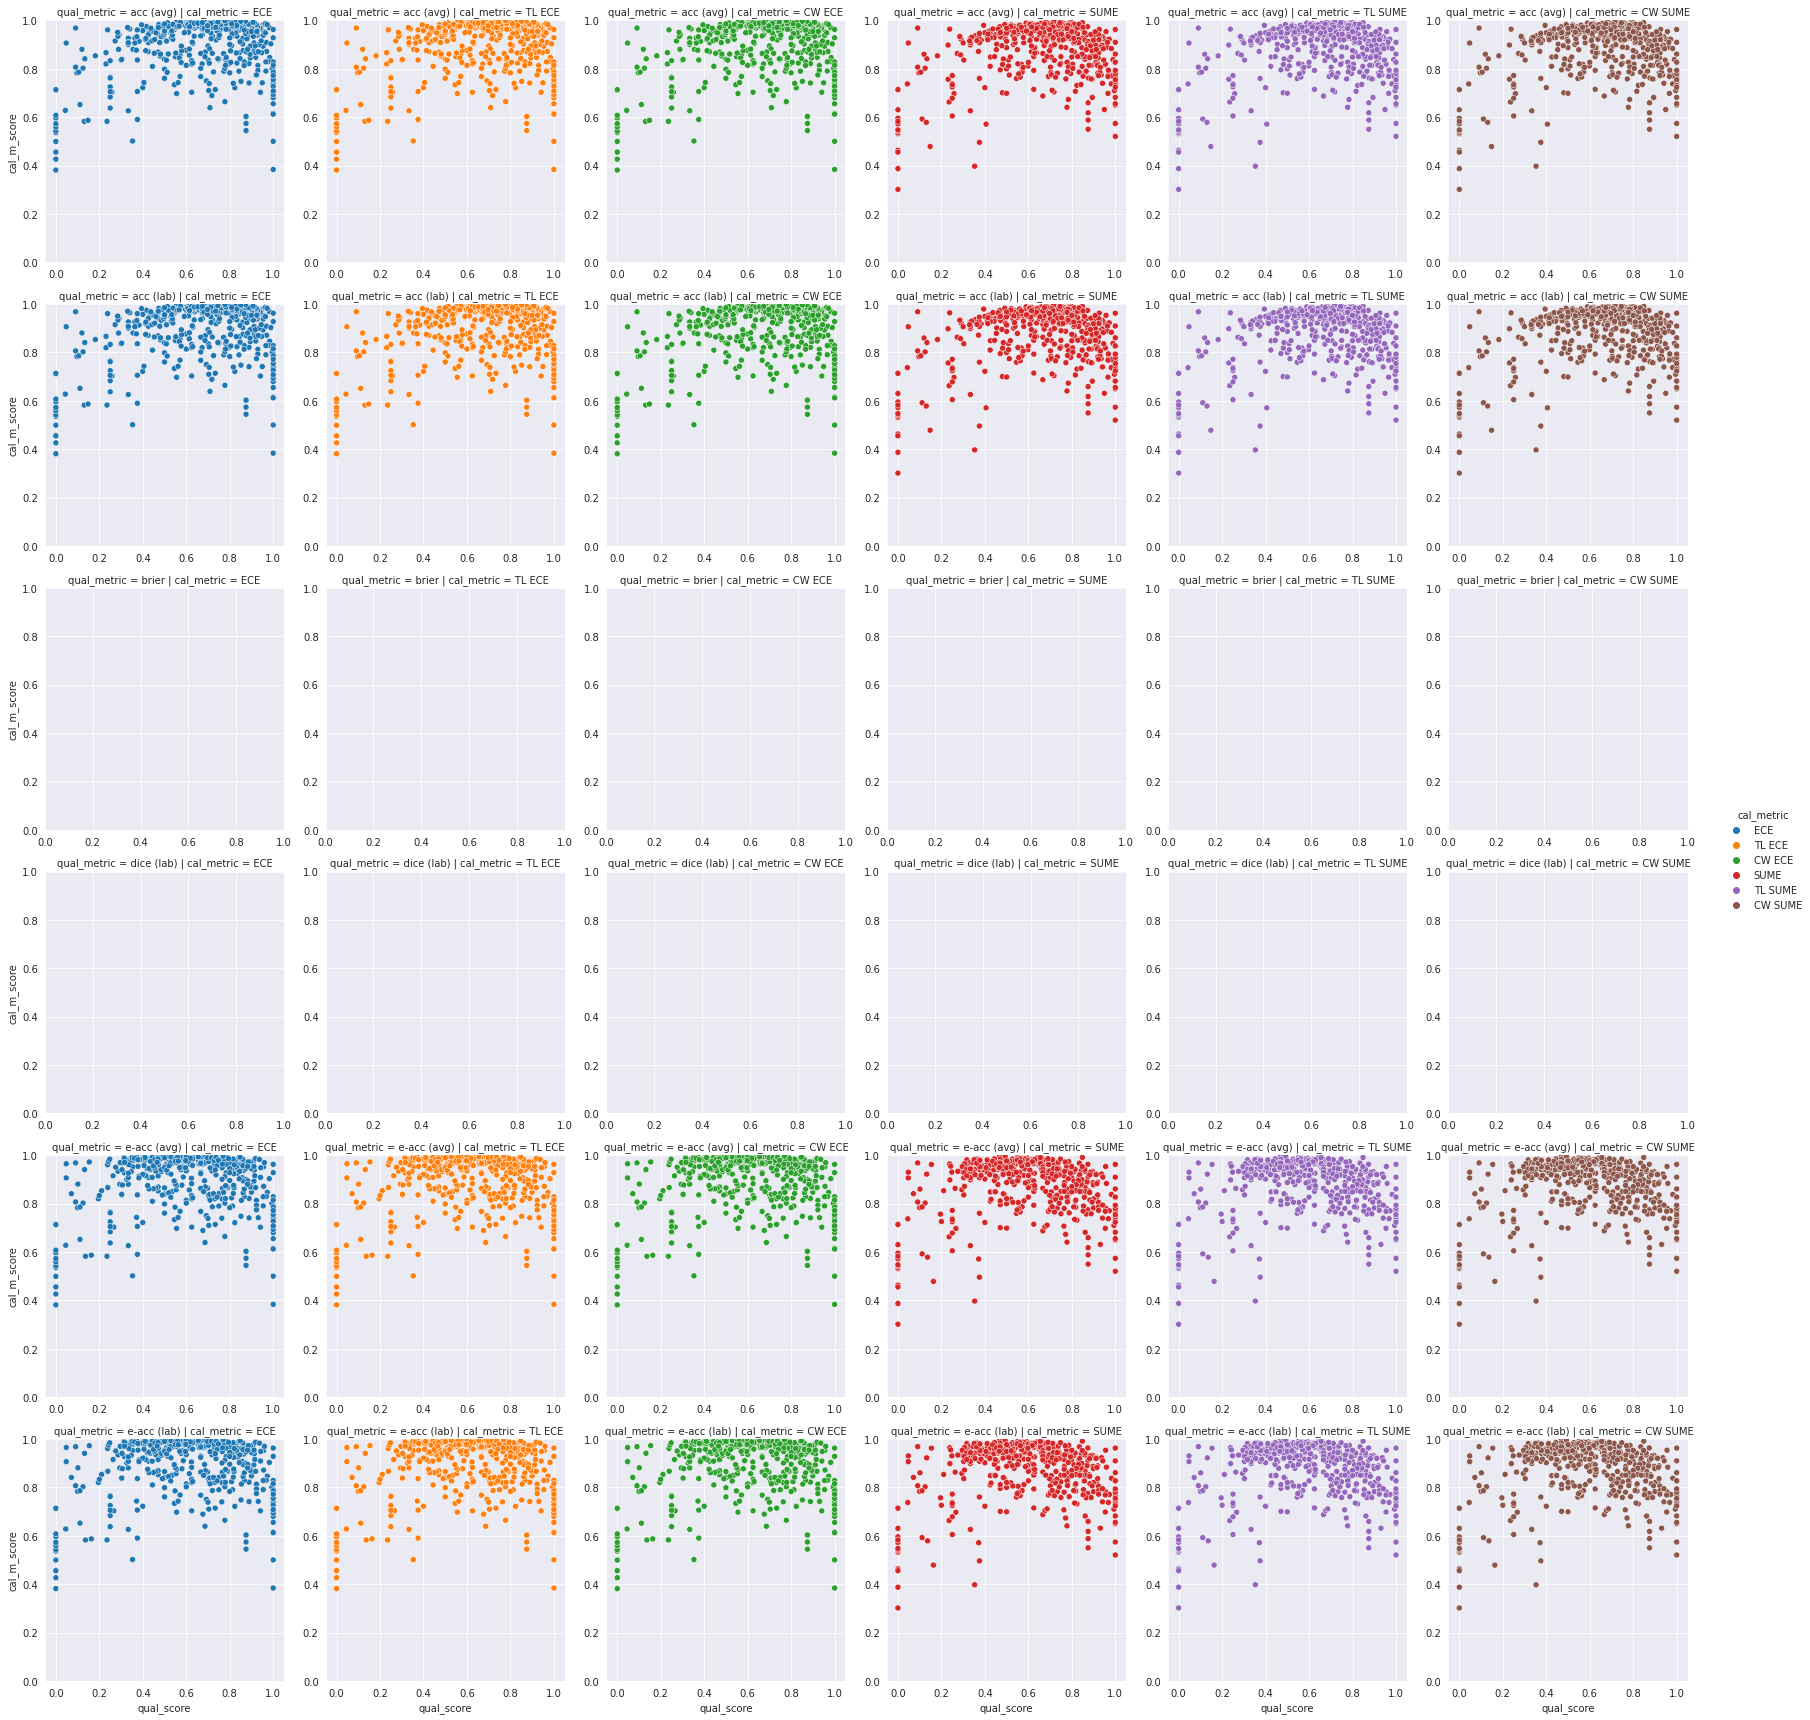

In [15]:
df_qm_sorted = unique_image_df.sort_values(by=["qual_metric", "cal_metric_type"])
g = sns.relplot(
    df_qm_sorted, 
    x="qual_score", 
    y="cal_m_score", 
    hue="cal_metric", 
    col="cal_metric", 
    row="qual_metric", 
    height=4, 
    aspect=1,
    facet_kws={'sharey': False, 'sharex': False}
    )
g.set(ylim=(0, 1))
g.tight_layout()